In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import keras
from keras.models import Model
from keras.layers import Add, Multiply, Dense, Dropout, Input, Lambda, concatenate #Merge
from keras.optimizers import adam
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Using TensorFlow backend.


# Prince Potential

In [2]:
def energy(x, a=1., b=0.8, c=0.2, d=0.5):
    x1 = x ** 8
    x2 = np.exp(-80. * x * x)
    x3 = np.exp(-80. * (x - 0.5) ** 2)
    x4 = np.exp(-40. * (x + 0.5) ** 2)
    return 4 * (a * x1 + b * x2 + c * x3 + d * x4)

In [3]:
def energy_loss(x, a=1., b=0.8, c=0.2, d=0.5):
    x1 = x ** 8
    x2 = tf.exp(-80. * x * x)
    x3 = tf.exp(-80. * (x - 0.5) ** 2)
    x4 = tf.exp(-40. * (x + 0.5) ** 2)
    return 4 * (a * x1 + b * x2 + c * x3 + d * x4)

(0.021176885008375803, 5.190775909439877)

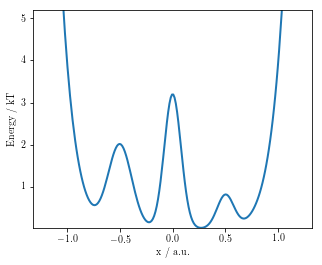

In [4]:
# Plot Prince potential
xrange = np.linspace(-1.2, 1.2, 200)
energies = energy(xrange)
plt.figure(figsize=(5, 4))
plt.plot(xrange, energies, linewidth=2)
plt.xlabel('x / a.u.')
plt.ylabel('Energy / kT')
plt.ylim(energies.min(), energies[int(energies.size / 2)] + 2.0)

# Model

In [5]:
# Initialize model

def reset_weights(model):
    session = keras.backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            
def init_model(model, x0):
    # reset weight in the beginning to get new model
    reset_weights(model)
    
    # Initialize until we get a mild displacement
    pred = model.predict([np.array([x0], dtype=np.float32), np.array([0], dtype=np.float32)])
    mu_x = pred[0, 2]
    sigma_x = pred[0, 3]
    while np.abs(mu_x - x0) > 0.3 or sigma_x < 0.01 or sigma_x > 0.3:
        reset_weights(model)
        pred = model.predict([np.array([x0], dtype=np.float32), np.array([0], dtype=np.float32)])    
        mu_x = pred[0, 2]
        sigma_x = pred[0, 3] 

In [6]:
def concat_layers(inp, layers):
    """ Serially concatenates a list of layers after the input, and returns a link to the last layer
    
    """
    layer = inp
    for l in layers:
        layer = l(layer)
    return layer

In [7]:
def compute_transformed_config(mu_sigma_w):
    """Reparametrisation and change shape to (batchsize,1). The array only contains positions after the transformation.
    """
    mu = mu_sigma_w[:, 0]
    sigma = mu_sigma_w[:, 1]
    w = mu_sigma_w[:, 2]
    result = tf.reshape(sigma * w + mu, shape=(-1, 1))
    return result

In [8]:
# DEFINE LAYERS
dim = 1
nnodes = [20, 20, 20]

# configuration input
input_x = Input(shape = (dim,), name='x')
# noise input
input_w = Input(shape = (dim,), name='w')

# encoder layers for Gaussian mean
mu_layers = []
for i, nn in enumerate(nnodes):
    mu_layers.append(Dense(nn, activation='softplus', name='mu_' + str(i+1)))
# end with linear layer so that we can have negative values
mu_layers.append(Dense(dim, activation='linear', name='mu_' + str(len(nnodes)+1)))    

# encoder layers for Gaussian standard deviation
sigma_layers = []
for i, nn in enumerate(nnodes):
    sigma_layers.append(Dense(nn, activation='softplus', name='sigma_' + str(i+1)))
sigma_layers.append(Dense(dim, activation='softplus', name='sigma_' + str(len(nnodes)+1)))    
    
# CONNECT NETWORK
# compute moments
mu_x = concat_layers(input_x, mu_layers)
sigma_x = concat_layers(input_x, sigma_layers)
# calculation of transformed configuration
mu_sigma_w = concatenate([mu_x, sigma_x, input_w])
transformed_config = Lambda(compute_transformed_config, name='y')(mu_sigma_w)
# compute moments again (for back proposal)
mu_y = concat_layers(transformed_config, mu_layers)
sigma_y = concat_layers(transformed_config, sigma_layers)
# define output
outputs = concatenate([input_x, input_w, mu_x, sigma_x, transformed_config, mu_y, sigma_y])

# MODEL
model = Model(inputs = [input_x, input_w], outputs = outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
mu_1 (Dense)                    (None, 20)           40          x[0][0]                          
                                                                 y[0][0]                          
__________________________________________________________________________________________________
sigma_1 (Dense)                 (None, 20)           40          x[0][0]                          
                                                                 y[0][0]                          
__________________________________________________________________________________________________
mu_2 (Dens

In [9]:
# is also included in loss_efficiency, but needed for MCMC
def pacc_barker_np(pred):
    """Calculate acceptance probabilty using Barker acceptance.
    """
    # Split data
    x = pred[:, 0]
    w = pred[:, 1]
    mu_x = pred[:, 2]
    sigma_x = pred[:, 3]
    y = pred[:, 4]
    mu_y = pred[:, 5]
    sigma_y = pred[:, 6]
    
    # proposal probabilities
    pprop_xy = np.exp(-(w**2) / 2.0) / sigma_x
    w_y = (x - mu_y) / sigma_y
    pprop_yx = np.exp(-(w_y**2) / 2.0) / sigma_y
    
    # densities probabilities
    p_x = np.exp(-energy(x))
    p_y = np.exp(-energy(y))
    
    # acceptance probability
    pacc = p_y * pprop_yx / (p_x * pprop_xy + p_y * pprop_yx)

    return pacc

In [10]:
def loss_efficiency(y_true, y_pred):
    """ Calculates the gradient of the loss score calculated with respect
    to the network lobes. Can be used as a loss function for a keras
    model

    Parameters
    ----------
    y_true: tensorflow tensor.
            parameter not needed for the calculation, added to comply with Keras
            rules for loss functions format.

    y_pred: tensorflow tensor with shape [batch_size, output_size]

    Returns
    -------
    loss_score: tensorflow tensor with shape [batch_size].
                the loss score
    
    """
    # Split data
    x = y_pred[:, 0]
    w = y_pred[:, 1]
    mu_x = y_pred[:, 2]
    sigma_x = y_pred[:, 3]
    y = y_pred[:, 4]
    mu_y = y_pred[:, 5]
    sigma_y = y_pred[:, 6]

    # proposal probabilities
    pprop_xy = tf.exp(-((w**2) / 2.0)) / sigma_x
    w_y = (x - mu_y) / sigma_y
    pprop_yx = tf.exp(-((w_y**2) / 2.0)) / sigma_y

    # densities probabilities
    p_x = tf.exp(-energy_loss(x))
    p_y = tf.exp(-energy_loss(y))
    
    # acceptance probability
    pacc = p_y * pprop_yx / (p_x * pprop_xy + p_y * pprop_yx)

    # spread
    spread = (x - y) ** 2

    return -pacc * spread

# Generate Monte Carlo run


In [11]:
# Noise intensity
sigma = 0.1
# Simulation starting point
x0 = -1.1

init_model(model, x0)

In [12]:
def generate_batch(x0, transformer, size=1024):
    """
    Gernate batch of size size by walking from x0 and accepting with Monta Carlo Acc.
    Parameters
    ----------
    transformer: keras model or float
        If keras model, model.predict([x, w]) will be used to propose y.
        If a float s is given, we will just use y = x + w s (Normal MCMC). s is the step size
    """
    try:
        float(transformer)
        nn = False
    except:
        nn = True
        
    x = np.zeros(size, np.float32)
    w = np.random.normal(size=size).astype(np.float32)
    xprop = np.zeros(size, np.float32)
    
    x[0] = x0
    for i in range(size-1):
        if nn:
            pred = transformer.predict([np.array([x[i]]), np.array([w[i]])])
        else:
            s = transformer
            y = x[i] + s * w[i]
            pred = np.array([[x[i], w[i], x[i], s, y, y, s]])
        pacc = pacc_barker_np(pred)
        xprop[i] = pred[0, 4]

        # accept or reject
        if np.random.rand(1) < pacc:
            x[i+1] = xprop[i]
        else:
            x[i+1] = x[i]
    
    return x, w, xprop

In [13]:
def select_batch(X, transformer, size=1024):
    """Select random batch of size size from data X. Return X, w and proposed y.
    """
    X = np.random.choice(X, size=size, replace=True)
    X = X.astype(np.float32)
    size = np.shape(X)[0]
    w = np.random.normal(size=size).astype(np.float32)
    xprop = np.zeros(size, np.float32)
    
    for i in range(size):
        pred = transformer.predict([X, w])
        xprop[i] = pred[0, 4]
    
    return X, w, xprop

In [14]:
# Test: generate walk with 10 steps and starting point -1.1
generate_batch(-1.1, model, size=10)

(array([-1.1       , -0.82860035, -0.86032236, -0.86032236, -0.86032236,
        -0.86032236, -0.65922624, -0.8070588 , -0.8070588 , -0.8089255 ],
       dtype=float32),
 array([ 0.64129233,  0.15799938,  0.10203191, -0.6242193 , -0.30392295,
         1.5687116 ,  0.3617396 ,  0.432805  ,  0.48941538, -1.2085593 ],
       dtype=float32),
 array([-0.82860035, -0.86032236, -0.8728408 , -0.9786157 , -0.9319661 ,
        -0.65922624, -0.8070588 , -0.81719893, -0.8089255 ,  0.        ],
       dtype=float32))

Text(0, 0.5, 'x')

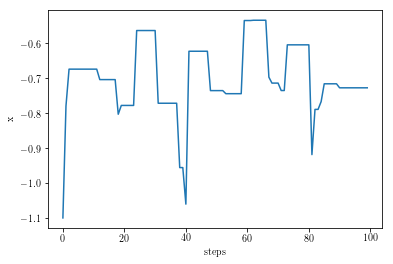

In [15]:
# Test: generate walk with 100 steps and starting point -1.1
x, w, xprop  = generate_batch(-1.1, model, size=100)
plt.plot(x)
plt.xlabel('steps')
plt.ylabel('x')

# MCMC

Text(0, 0.5, 'x')

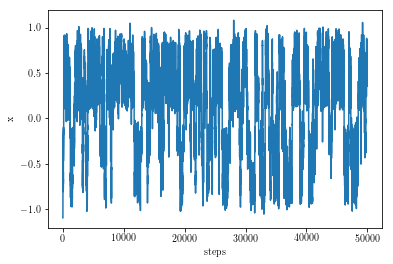

In [32]:
# MCMC for the potential, starting in the lower well at -1.1
x_MCMC, w_MCMC, xprop_MCMC  = generate_batch(-1.1, 0.1, size=50000)
plt.plot(x_MCMC)
plt.xlabel('steps')
plt.ylabel('x')

# Train the Netwrok

In [17]:
def train(x0, loss_function, learning_rate=0.001, batchsize=200, nepochs=500, return_samples=False, verbose=True):
    try:
        float(x0)
        generate = True
    except:
        if np.shape(x0)[0] <= batchsize:
            raise ValueError('If init data is provided, it must exceed the batchsize')
        generate = False        
    
    # Compile Model
    optimizer = adam(lr = learning_rate)
    # use our loss function
    model.compile(optimizer = optimizer, loss=loss_function)
    
    losses = []
    
    # dummy variable
    y_empty = np.zeros((batchsize, 4))

    if return_samples:
        samples_x = []
        samples_w = []

    for e in range(nepochs):
        # generate batch
        if generate:
            x, w, xprop = generate_batch(x0, model, size=batchsize)
            x0 = x[-1]
        else:
            x, w, xprop = select_batch(x0, model, size=batchsize)
        # predict through network ??? überflüssig
        pred = model.predict([x, w])
        # compute losses ??? überflüssig
        pred_loss = loss_efficiency(pred, pred)
        # train
        loss = model.train_on_batch([x, w], y_empty)
        # post-processing
        losses.append(loss)
        if return_samples:
            samples_x.append(x)
            samples_w.append(w)
        # report
        if verbose and e%10 == 0:
            print("Epoch: ",e, loss)

    if return_samples:
        return losses, np.concatenate(samples_x), np.concatenate(samples_w)
    else:
        return losses

In [18]:
def sample_train(x0, batchsize, learning_rate=0.001, nrepeats=3, nsamples=100000):
    """Sample new positions (based on the network) and train with them the netwrok. 
    This is done nrepeats times. Everytime a new model is trained.
    Return all losses
    """
    all_losses = []
    for n in range(nrepeats):
        print('STARTING: repeat = ', n)
        init_model(model, x0)
        losses = train(x0, loss_efficiency, learning_rate=learning_rate, 
                       batchsize=batchsize, nepochs=int(nsamples/batchsize), 
                       return_samples=False)
        all_losses.append(losses)
    return all_losses

In [19]:
losses_bs500_lr002 = sample_train(x0, 500, learning_rate=0.002, nrepeats=5, nsamples=60000) #60000'

STARTING: repeat =  0
Epoch:  0 -0.0040391535
Epoch:  10 -0.17285077
Epoch:  20 -0.1223931
Epoch:  30 -0.16493094
Epoch:  40 -0.22194836
Epoch:  50 -0.2107648
Epoch:  60 -0.22025146
Epoch:  70 -0.23006853
Epoch:  80 -0.24011704
Epoch:  90 -0.25958797
Epoch:  100 -0.42530942
Epoch:  110 -0.1407457
STARTING: repeat =  1
Epoch:  0 -0.00084548496
Epoch:  10 -0.1770162
Epoch:  20 -0.178534
Epoch:  30 -0.18374722
Epoch:  40 -0.1840394
Epoch:  50 -0.2046597
Epoch:  60 -0.19768122
Epoch:  70 -0.18441541
Epoch:  80 -0.202852
Epoch:  90 -0.25721535
Epoch:  100 -0.24296969
Epoch:  110 -0.25304234
STARTING: repeat =  2
Epoch:  0 -0.0045572757
Epoch:  10 -0.17458895
Epoch:  20 -0.18008524
Epoch:  30 -0.20118612
Epoch:  40 -0.19263536
Epoch:  50 -0.19399944
Epoch:  60 -0.18622953
Epoch:  70 -0.24274938
Epoch:  80 -0.2573384
Epoch:  90 -0.3648301
Epoch:  100 -0.37582415
Epoch:  110 -0.49351653
STARTING: repeat =  3
Epoch:  0 -9.406294e-05
Epoch:  10 -0.083135046
Epoch:  20 -0.21818855
Epoch:  30 -0.1

Text(0.5, 1.0, 'Training Loss')

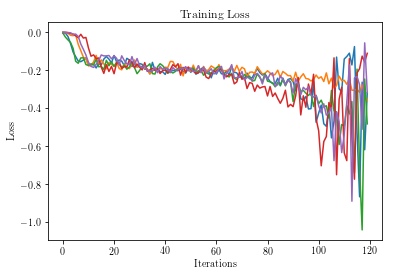

In [20]:
for l in losses_bs500_lr002:
    plt.plot(l)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title("Training Loss")


# Results

In [21]:
def create_results(x0, batchsize=500, nepochs=100, learning_rate=0.002, xrange=xrange):
    init_model(model, x0)
    pred_before = model.predict([xrange.astype(np.float32), np.zeros(xrange.size, dtype=np.float32)])
    losses, samples_x, samples_w = train(x0, loss_efficiency, learning_rate=learning_rate, 
                                         batchsize=batchsize, nepochs=nepochs, 
                                         return_samples=True)
    pred_after = model.predict([xrange.astype(np.float32), np.zeros(xrange.size, dtype=np.float32)])
    return losses, samples_x, samples_w, pred_before, pred_after

In [22]:
losses, samples_x, samples_w, pred_before, pred_after = create_results(-1.1, batchsize=500, nepochs=500)

Epoch:  0 -3.9801143e-05
Epoch:  10 -0.08158203
Epoch:  20 -0.1769649
Epoch:  30 -0.18817791
Epoch:  40 -0.19868137
Epoch:  50 -0.22283654
Epoch:  60 -0.23350738
Epoch:  70 -0.28310394
Epoch:  80 -0.31984958
Epoch:  90 -0.21771811
Epoch:  100 -0.17308034
Epoch:  110 -0.3527262
Epoch:  120 -0.22415696
Epoch:  130 -0.71853864
Epoch:  140 -0.6753239
Epoch:  150 -0.46838185
Epoch:  160 -0.4454779
Epoch:  170 -0.45012313
Epoch:  180 -0.34601685
Epoch:  190 -0.40572914
Epoch:  200 -0.32732272
Epoch:  210 -0.59435225
Epoch:  220 -0.69265926
Epoch:  230 -0.3396089
Epoch:  240 -1.2465284
Epoch:  250 -0.12124887
Epoch:  260 -0.18015474
Epoch:  270 -0.34227175
Epoch:  280 -0.21692468
Epoch:  290 -0.30323362
Epoch:  300 -0.46886683
Epoch:  310 -0.20163122
Epoch:  320 -0.2105806
Epoch:  330 -0.136385
Epoch:  340 -0.46626318
Epoch:  350 -0.37792125
Epoch:  360 -0.596715
Epoch:  370 -0.60651255
Epoch:  380 -0.14536463
Epoch:  390 -0.60418916
Epoch:  400 -0.41628006
Epoch:  410 -0.6216349
Epoch:  420 

Text(0.5, 1.0, 'after')

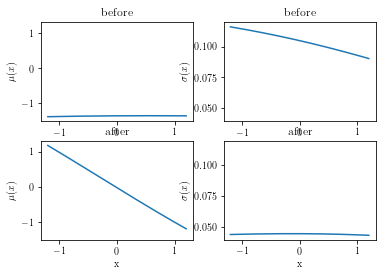

In [23]:
mu1 = plt.subplot(221)
plt.plot(xrange, pred_before[:, 2])
plt.ylabel(r'$\mu(x)$')
plt.title("before")

sig1 = plt.subplot(222)
plt.plot(xrange, pred_before[:, 3])
plt.ylabel(r'$\sigma(x)$')
plt.title("before")


plt.subplot(223, sharey = mu1)
plt.plot(xrange, pred_after[:, 2])
plt.ylabel(r'$\mu(x)$')
plt.xlabel('x')
plt.title("after")

plt.subplot(224, sharey = sig1)
plt.plot(xrange, pred_after[:, 3])
plt.xlabel('x')
plt.ylabel(r'$\sigma(x)$')
plt.title("after")

Text(0.5, 0, 'Step')

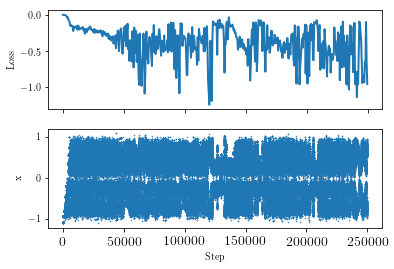

In [24]:
ax2 = plt.subplot(211)
plt.plot(losses, linewidth=2)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.ylabel('Loss')

ax1 = plt.subplot(212)
plt.plot(samples_x, '.', markersize=1)
plt.setp(ax1.get_xticklabels(), fontsize=14)
plt.ylabel('x')
plt.xlabel('Step')

In [25]:
#sample with trained model
x, w, xprop = generate_batch(x0, model, size=50000)

Normalisation of the distribution

$\int_{-\infty}^{\infty} \exp\{-4[x⁸+0.8 \exp(-80x²) +0.2 \exp(-80(x-0.5)²) + 0.5 \exp(-40(x+0.5)²)]\} \approx 0.8979$

Text(0.5, 1.0, 'Distribution')

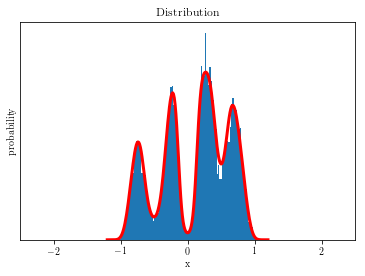

In [26]:
plt.hist(x, 100, density=True)#, orientation='horizontal');
plt.plot(xrange, 1 / 0.8979 * np.exp(-energy(xrange)), color='red', linewidth=3)
plt.xlim(-2.5, 2.5)
plt.yticks([])
plt.ylabel('probability')
plt.xlabel('x')
plt.title('Distribution')


Text(0.5, 1.0, 'Distribution')

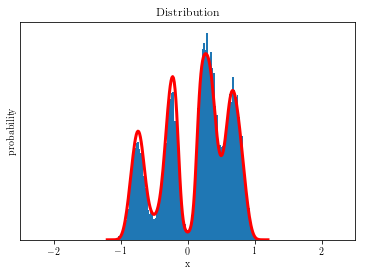

In [33]:
plt.hist(x_MCMC, 100, density=True)#, orientation='horizontal');
plt.plot(xrange, 1 / 0.8979 * np.exp(-energy(xrange)), color='red', linewidth=3)
plt.xlim(-2.5, 2.5)
plt.yticks([])
plt.ylabel('probability')
plt.xlabel('x')
plt.title('Distribution')

Autocorrelation function

$acf(X, t)=\frac{\sum_i X_i X_{i-t}}{\sum_i X_i X_{i}}$

In [34]:
def acf(x):
    cc = []
    for t in range(1, 100):
        # make data mean free
        x -= np.mean(x)
        cc.append(np.sum(x[:-t] * x[t:]) / np.sum(x[:-t] * x[:-t])) #warum x[:-t] und nicht x[t:]
    return np.concatenate([[1], cc])

In [35]:
len(samples_x)

250000

Text(0, 0.5, 'Autocorrelation')

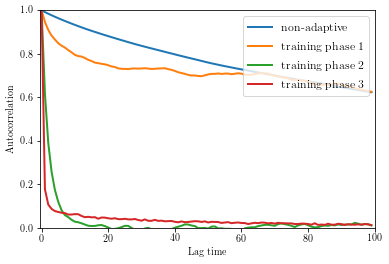

In [36]:
# Plot Autocorrelation
plt.plot(acf(x_MCMC), linewidth=2, label='non-adaptive')
plt.plot(acf(samples_x[:5000]), linewidth=2, label='training phase 1')
plt.plot(acf(samples_x[10000:30000]), linewidth=2, label='training phase 2')
plt.plot(acf(samples_x[40000:]), linewidth=2, label='training phase 3')
plt.xlim(-0.5, 100)
plt.ylim(0, 1)
plt.legend(loc=1, fontsize=12)
plt.xlabel('Lag time')
plt.ylabel('Autocorrelation')